## Final Project
### Liam Pronovost

Identifying the type of cancer present in a patient can be vital to the treatment of the disease. Often, recognition of disease type takes time and evaluation of data. With this project, I attempt to see how accurately a series of algorithms (Random Forest, Decision Tree, and Logistic Regression) can predict the type of cancer a patient has been diagnosed with. The dataset was downloaded from kaggle https://www.kaggle.com/datasets/brunogrisci/brain-cancer-gene-expression-cumida

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB

In [2]:
brain_data = pd.read_csv('Brain_GSE50161.csv').drop(columns = 'samples')
brain_data

,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,ependymoma,12.498150,7.604868,6.880934,9.027128,4.176175,7.224920,6.085942,6.835999,5.898355,...,9.979005,9.926470,12.719785,12.777792,5.403657,4.870548,4.047380,3.721936,4.516434,4.749940
1,ependymoma,13.067436,7.998090,7.209076,9.723322,4.826126,7.539381,6.250962,8.012549,5.453147,...,11.924749,11.215930,13.605662,13.401342,5.224555,4.895315,3.786437,3.564481,4.430891,4.491416
2,ependymoma,13.068179,8.573674,8.647684,9.613002,4.396581,7.813101,6.007746,7.178156,8.400266,...,12.154405,11.532460,13.764593,13.477800,5.303565,5.052184,4.005343,3.595382,4.563494,4.668827
3,ependymoma,12.456040,9.098977,6.628784,8.517677,4.154847,8.361843,6.596064,6.347285,4.900380,...,11.969072,11.288801,13.600828,13.379029,4.953429,4.708371,3.892318,3.759429,4.748381,4.521275
4,ependymoma,12.699958,8.800721,11.556188,9.166309,4.165891,7.923826,6.212754,6.866387,5.405628,...,11.411701,11.169317,13.751442,13.803646,4.892677,4.773806,3.796856,3.577544,4.504385,4.541450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,pilocytic_astrocytoma,12.658228,8.843270,7.672655,9.125912,5.495477,8.603892,7.747514,5.828978,6.926720,...,13.170441,12.676080,14.124837,13.996436,4.913579,4.399176,3.878855,3.680103,4.726784,4.564637
126,pilocytic_astrocytoma,12.812823,8.510550,8.729699,9.104402,3.967228,7.719089,7.092496,6.504812,6.157163,...,13.040267,12.403316,13.978009,13.812916,5.189600,4.912618,3.764800,3.664920,4.628355,4.761351
127,pilocytic_astrocytoma,12.706991,8.795721,7.772359,8.327273,6.329383,8.550471,6.613332,6.308945,7.494852,...,12.825383,12.439265,14.328373,14.008693,4.931460,4.712895,3.913637,3.700964,4.764693,4.834952
128,pilocytic_astrocytoma,12.684593,8.293938,7.228186,8.494428,6.049414,8.214729,7.287758,5.732710,6.296021,...,13.116581,12.657967,14.390346,14.194904,4.871092,4.739400,3.782980,3.920363,4.665584,4.613326


Luckily, the data is complete and has no missing values. Seeing that its a very structured and clean data set, there is no data cleaning necessary.

In [3]:
print(f"Number of null values in the data set: {brain_data.isna().sum().sum()}")

Number of null values in the data set: 0


### Data Exploration

<AxesSubplot:xlabel='type', ylabel='Count'>

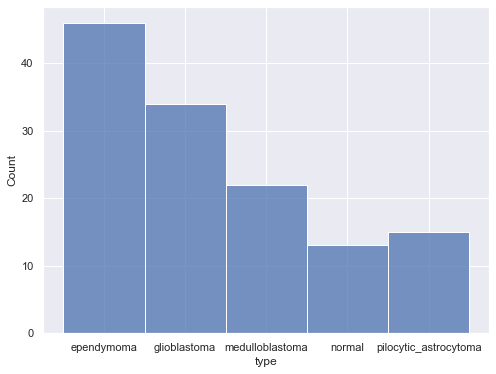

In [4]:
sns.set(rc ={'figure.figsize':(8,6)})
sns.histplot(data = brain_data, x = 'type')

Seeing there are over 20,000 genes in this dataset, there is a lot to explore. Rather than looking at all the genes in the dataset, I want to look at the ones that have significantlly different expression compared to the others. The code chunk below compares the expression of the genes by cancer type. Using a t-test and standard deviation, genes with a significant p-value with a mean difference of 7.5 standard deviations are considered to be our genes of interest (the 7.5 is rather arbitrary, it just allowed for a good number of genes). 

In [5]:
genes_of_interest = set()
genomic_data = brain_data[['type']+brain_data.columns[2::].to_list()]
for ctype in genomic_data['type'].unique():
    exp = genomic_data[genomic_data.type == ctype].drop(columns=['type'])
    n = exp.shape[0]
    pop = genomic_data[genomic_data['type'] != ctype]
    sample = pop.sample(n)
    for gene in exp.columns:
        p_val = stats.ttest_ind(pop[gene], exp[gene])[1]
        dif = abs(np.mean(pop[gene]) - np.mean(exp[gene]))
        std = np.std(pop[gene])
        if p_val < 0.0001 and dif >= std*7.5:
            genes_of_interest.add(gene)
genes = sorted(list(genes_of_interest))

In [6]:
def get_split(l):
    a = len(l)%4
    if a == 1:
        return [0,len(l)//4,2*len(l)//4,3*len(l)//4+1,len(l)]  
    elif a == 2:
        return [0,len(l)//4,2*len(l)//4+1,3*len(l)//4+1,len(l)]
    return [0,len(l)//4,2*len(l)//4,3*len(l)//4,len(l)] 

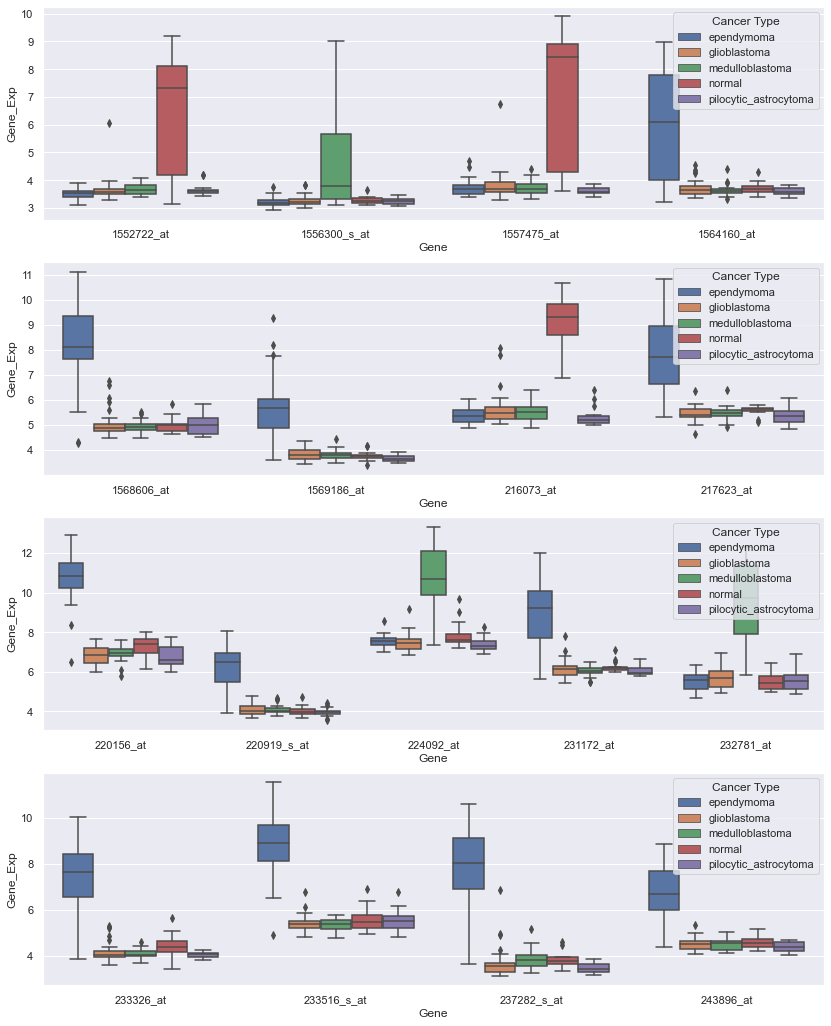

In [7]:
sns.set(rc ={'figure.figsize':(14,18)})
fig, axs = plt.subplots(4,1)
names = ['Cancer Type','Gene_Exp']
splits = get_split(genes)
for i in range(0,len(splits)-1):
    graph_data = pd.DataFrame()
    genes_part = genes[splits[i]:splits[i+1]]
    gene = genes_part[0]
    graph_data[names] = genomic_data[['type', gene]]
    graph_data['Gene'] = [gene for i in range(graph_data.shape[0])]
    for gene in genes_part[1::]:
        data = pd.DataFrame()
        data[names] = genomic_data[['type', gene]]
        data['Gene'] = [gene for i in range(data.shape[0])]
        graph_data = pd.concat([graph_data,data])

    sns.boxplot(data=graph_data, x = 'Gene', y = 'Gene_Exp', hue = 'Cancer Type', ax = axs[i])

<AxesSubplot:>

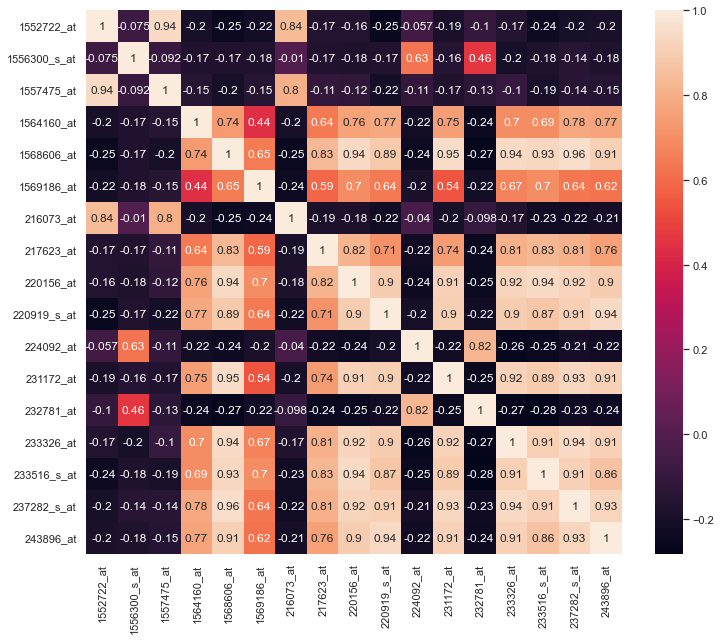

In [8]:
sns.set(rc ={'figure.figsize':(12,10)})
sns.heatmap(brain_data[genes].corr(), annot = True)

<AxesSubplot:ylabel='Count'>

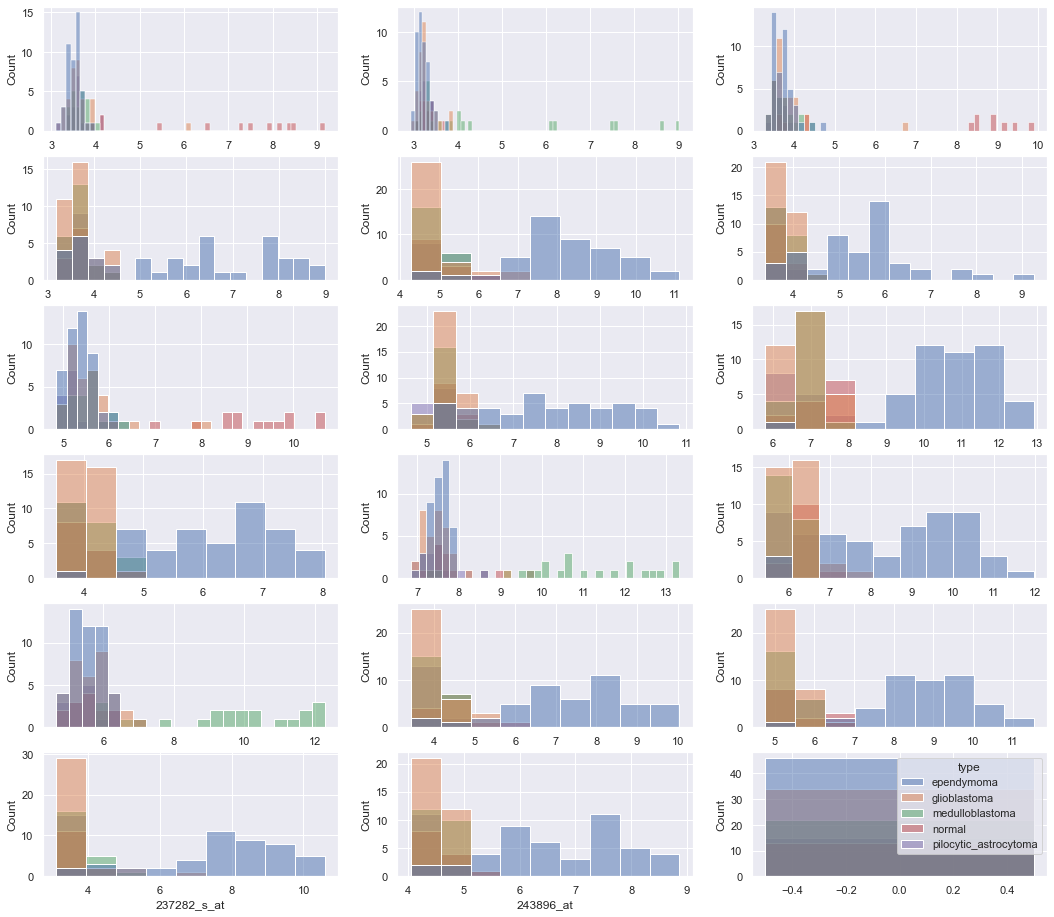

In [25]:
sns.set(rc ={'figure.figsize':(18,16)})
fig, axs = plt.subplots(6,3)
count = 0
for gene in genes:
    sns.histplot(data=brain_data, x = gene, hue = 'type', ax = axs[count//3,count%3], legend=False)
    count+=1
sns.histplot(data=brain_data, x = 0, hue = 'type', ax = axs[5,2], legend=True)

### Data Preperation
 The data only requires splitting and scaling. Seeing that a negative gene expression doesn't make sense, I chose to use the MinMaxScaler instead of the StandardScalar. I also chose to do a 60/40 split of my data, seeing that the data frame isn't that large, I would like a larger testing set.

In [26]:
Xb = brain_data.drop(columns='type')
yb = brain_data['type']
Xb[Xb.columns] = MinMaxScaler().fit_transform(Xb)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=.4, random_state=42)

### Model Training
The three models trained will be the RandomForestClassifier, the DecisionTreeClassifier, and LogisticRegression. The best model will be tuned and explored.

Accuracy for RandomForestClassifier(random_state=42) training set: 1.0
Accuracy for RandomForestClassifier(random_state=42) testing set: 0.9230769230769231
Accuracy for DecisionTreeClassifier(random_state=42) training set: 1.0
Accuracy for DecisionTreeClassifier(random_state=42) testing set: 0.8846153846153846
Accuracy for LogisticRegression(max_iter=500, random_state=42) training set: 1.0
Accuracy for LogisticRegression(max_iter=500, random_state=42) testing set: 0.9230769230769231


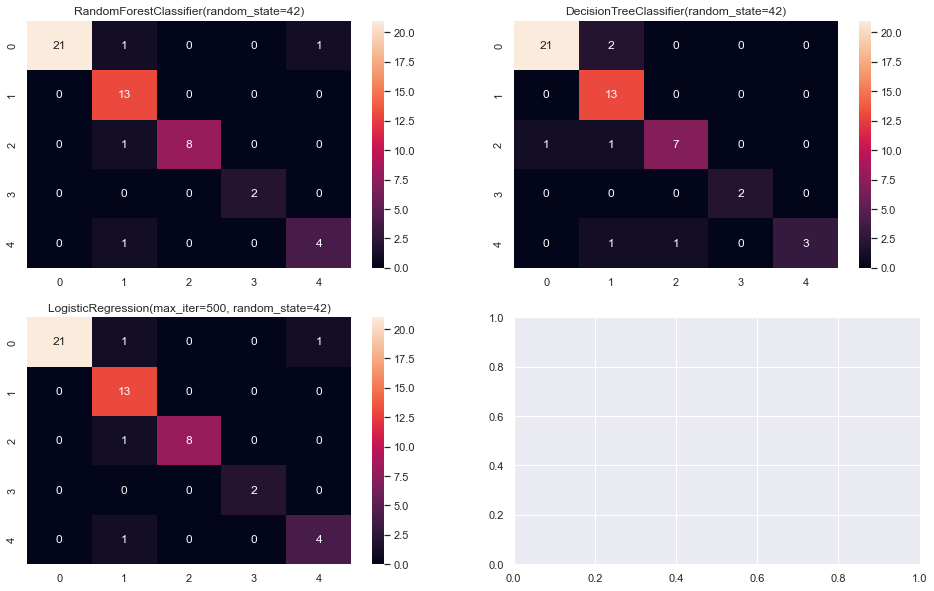

In [27]:
sns.set(rc ={'figure.figsize':(16,10)})
models = [RandomForestClassifier(random_state=42), DecisionTreeClassifier(random_state=42), 
          LogisticRegression(random_state=42, max_iter=500)]
fig, axs = plt.subplots(2,2)
count = 0
for model in models:
    model.fit(Xb_train, yb_train)
    yb_pred = model.predict(Xb_test)
    yb_train_pred = model.predict(Xb_train)
    cf_mat = confusion_matrix(y_true=yb_test, y_pred=yb_pred)
    sns.heatmap(cf_mat, annot = True, ax = axs[count//2,count%2])
    axs[count//2,count%2].title.set_text(str(model))
    print(f"Accuracy for {model} training set: {accuracy_score(y_true=yb_train, y_pred=yb_train_pred)}")
    print(f"Accuracy for {model} testing set: {accuracy_score(y_true=yb_test, y_pred=yb_pred)}")
    count+=1

### Tuning
Using GridSearchCV, we can tune the best model (RandomForestClassifier). Then we can look at the feature importances of our model. 

In [28]:
rfc_params = {'bootstrap':[True,False], 'max_depth':range(5,12), 'n_estimators':[100,200,300]}
grid_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=rfc_params, cv = 8)
grid_rfc.fit(Xb_train, yb_train)

GridSearchCV(cv=8, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False], 'max_depth': range(5, 12),
                         'n_estimators': [100, 200, 300]})

In [38]:
print(rfc_params)

{'bootstrap': [True, False], 'max_depth': range(5, 12), 'n_estimators': [100, 200, 300]}


Accuracy for training set: 1.0
Accuracy for testing set: 0.9423076923076923


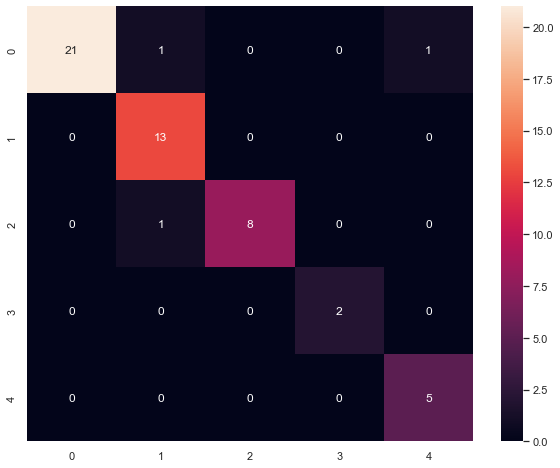

In [29]:
sns.set(rc={'figure.figsize':(10,8)})
best_rfc = grid_rfc.best_estimator_
yb_pred = best_rfc.predict(Xb_test)
yb_train_pred = best_rfc.predict(Xb_train)
cf_mat = confusion_matrix(y_true=yb_test, y_pred=yb_pred)
sns.heatmap(cf_mat, annot = True)
print(f"Accuracy for training set: {accuracy_score(y_true=yb_train, y_pred=yb_train_pred)}")
print(f"Accuracy for testing set: {accuracy_score(y_true=yb_test, y_pred=yb_pred)}")

In [36]:
grid_rfc.best_params_

{'bootstrap': False, 'max_depth': 5, 'n_estimators': 100}

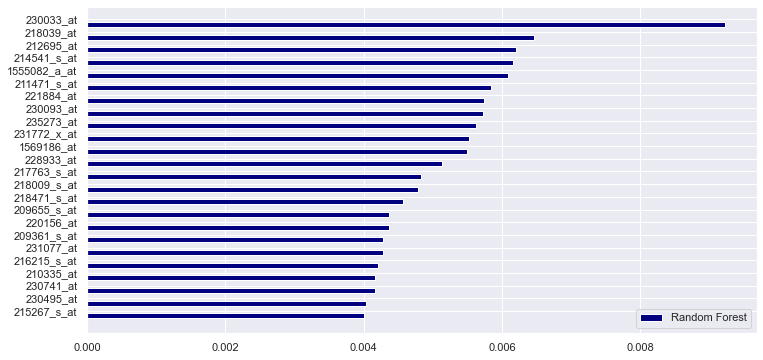

In [30]:
feature_importance=pd.DataFrame({'rfc':best_rfc.feature_importances_,},
                                index=Xb.columns)
feature_importance.sort_values(by='rfc',ascending=True,inplace=True)
my_feats = feature_importance[feature_importance['rfc']>0.004]
index = np.arange(len(my_feats))
fig, ax = plt.subplots(figsize=(12,6))
rfc_feature=ax.barh(index,my_feats['rfc'],0.4,color='navy',label='Random Forest')
ax.set(yticks=index+0.4,yticklabels=my_feats.index)

ax.legend()
plt.show()

Here I compare the feature importances to the genes I thought had significance in the previous section.

In [31]:
matches = []
for gene in genes:
    if my_feats.index.to_list().count(gene) > 0:
        matches.append(gene)
matches

['1569186_at', '220156_at']

Only one of the significant genes overlapped with the feature importances.

### Discussion
It seems that all three original classifiers were able to accurately predict the type of cancer present. After tuning, the RandomForestClassifier increased in accuracy. None of the models seemed to overfit the training set. In conclusion, the model was able to accurately predict cancer type. Interestingly enough, only one of our genes of interests was included in the top feature importances. 